# Pipeline for advanced lane line detection in singel images
#### Author: Pengmian Yan
#### Project: P2 Advanced Lane Finding


## Import

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image
import matplotlib.image as mpimg
%matplotlib qt

## Camera Calibration

In [2]:
#prepare object points 
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Arrays to store object points and image points from all images
objpoints = [] #3d object points in real world space
imgpoints = [] #2d image points in image plane

#make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#plt.imshow(images)

# Step through the list and search for chessboard corners
for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #find the chessboard corners
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
#     # Draw and display the corners   
#     cv2.drawChessboardCorners(img,(9,6),corners,ret)
#     plt.imshow(img)
#     cv2.waitKey(500)

import pickle
%matplotlib inline

# Test undistortion on an image
img =  cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1],img.shape[0])

# Do camera calibration given object points and image points
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

# dst = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('after_calibration/test_undist.jpg',dst)

# # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# #pickle.dump( dist_pickle, open( "Result/camera.p", "wb" ) )
# parameter = open( "Result/camera.p","wb")
# pickle.dump(dist_pickle,parameter,-1)

## Color and gradien threshold

In [3]:
def ColorGradienThreshold(img, s_thresh=(140, 255), sx_thresh=(50, 170)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel s
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #gray binary
    binary = np.zeros_like(s_channel)
    binary[(sxbinary==1) | (s_binary==1)] =1
    gray_binary = np.dstack((binary, binary, binary)) * 255
    # Stack each channel
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
#     return color_binary
#     return gray_binary
    return binary

## Perspective Transform

In [4]:
def warper(img,src,dst):
    '''
    Tansform the perspective to Bird-eye view.
    '''
    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    
    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform, M:
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img
    


## Finding the lines

In [5]:
def find_lane_pixels(binary_warped):
    '''
    Finding the lines in warped binary images
    '''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    #print(histogram.shape)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 14
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 25

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzero)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        # good_left_inds = nonzero[(nonzerox>win_xleft_low)&(nonzerox<win_xleft_high)&(nonzeroy>win_y_low)&(nonzeroy<win_y_high)]
        # good_right_inds = nonzero[(nonzerox>win_xright_low)&(nonzerox<win_xright_high)&(nonzeroy>win_y_low)&(nonzeroy<win_y_high)]
        good_left_inds = []
        good_right_inds = []
        for i in range(nonzerox.shape[0]):
            if (nonzeroy[i]>win_y_low)&(nonzeroy[i]<win_y_high):
                if (nonzerox[i]>win_xleft_low)&(nonzerox[i]<win_xleft_high):
                    good_left_inds.append(i)
                if (nonzerox[i]>win_xright_low)&(nonzerox[i]<win_xright_high):
                    good_right_inds.append(i)    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds).astype(np.int64)
        
        right_lane_inds = np.concatenate(right_lane_inds).astype(np.int64)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


## Fit Polynomial

In [6]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return ploty,left_fit,right_fit,out_img



## Curvature Calculation

In [7]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5/np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


## Position Estimation

In [8]:
def estimate_lateral_Positon(ploty, left_fit, right_fit, xmax):
    '''
    Estimation of the lateral position of car with respect to the lane center
    '''
    # Define y-value where we want estimate the latera position
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #Calculation of the correspond x Positon
    x_left = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    
    #Calulation of the lateral position in pixels
    lateral_position = -(x_left - (xmax - x_right))/2
    
    #Compute the lateral position in real world
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lateral_position_real = lateral_position*xm_per_pix
    
    return lateral_position_real


## Main Function

(2334.0447134965639, 1623.4118412903574)
-0.224029894067


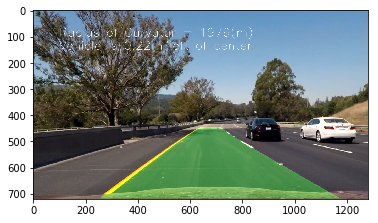

In [23]:
# # Test undistortion  and gradient on two image
img =  cv2.imread('test_images/test6.jpg')
img_size = (img.shape[1],img.shape[0])
undist = cv2.undistort(img, mtx, dist, None, mtx)
# cv2.imwrite('output_images/test2_undist.jpg',undist)
binary_output = ColorGradienThreshold(undist)
#cv2.imwrite('output_images/straight_lines1_binary_color.jpg',binary_output)
#cv2.imwrite('output_images/test2_binary.jpg',binary_output)
# plt.imshow(binary_output,cmap='gray')


# img2 =  cv2.imread('test_images/straight_lines2.jpg')
# dst2 = cv2.undistort(img2, mtx, dist, None, mtx)
# #cv2.imwrite('output_images/straight_lines1_undist.jpg',dst)
# binary_output2 = ColorGradienThreshold(dst2)
# #cv2.imwrite('output_images/straight_lines1_binary_color.jpg',binary_output)
# #cv2.imwrite('output_images/straight_lines2_binary.jpg',binary_output2)
# #plt.imshow(binary_output2,cmap='gray')


# #make a list of calibration images
# images = glob.glob('test_images/*.jpg')

# # Step through the list and find lane line in each image
# for idx,fname in enumerate(images):
#     img = cv2.imread(fname)
#     #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
#     # undistorte the images
#     dst = cv2.undistort(img, mtx, dist, None, mtx)
#     cv2.imwrite('output_images/'+fname+'_undist.jpg',dst)

#Perspective Transform
#source points:
src = np.float32(
[[600, 446],
[237, img_size[1]],
[1082, img_size[1]],
[680, 446]])
#destination points
dst = np.float32(
[[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

img_warped = warper(binary_output,src,dst)
# plt.imshow(img_warped)
#cv2.imwrite('output_images/test2_warped.jpg',img_warped)
ploty,left_fit,right_fit,img_warped_lines = fit_polynomial(img_warped)
# plt.imshow(img_warped_lines)
#cv2.imwrite('output_images/test1_warped_lines.jpg',test1_warped_lines)
curvature = measure_curvature_real(ploty,left_fit,right_fit)
print(curvature)
Car_lateral_Position = estimate_lateral_Positon(ploty,left_fit,right_fit,img.shape[1])
print(Car_lateral_Position)

# #draw the detected lane line on an empty image
# leftx, lefty, rightx, righty, lane_warped = find_lane_pixels(test1_warped)
# lane_warped[lefty, leftx] = [255, 0, 0]
# lane_warped[righty, rightx] = [0, 0, 255]
# plt.imshow(lane_warped)

# #Warp the detected lane boundaries back
# lane_warpedback = warper(lane_warped,dst,src)
# plt.imshow(lane_warpedback)
# # cv2.imwrite('output_images/test1_lane_warpedback.jpg',lane_warpedback)
# #put the lines on the inital image
# test1_with_lane = cv2.addWeighted(dst1, 0.7, lane_warpedback, 1.2, 0)
# # plt.imshow(test1_with_lane)
# cv2.imwrite('output_images/test1_with_lane.jpg',test1_with_lane)

# Create an image to draw the lines on
warp_zero = np.zeros_like(img_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = warper(color_warp,dst,src)

# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

#display the curvature and the position of car
text1 = 'Radius of Curvatur = '+ str(round(np.mean(curvature)).astype(np.int64)) + '(m)'
if Car_lateral_Position < 0:
    text2 = 'Vehicle is ' + str(round(np.absolute(Car_lateral_Position),2)) + 'm left of center'
elif Car_lateral_Position > 0:
    text2 = 'Vehicle is ' + str(round(np.absolute(Car_lateral_Position),2)) + 'm right of center'
else:
    text2 = 'Vehicle is on the center of lane'                      
cv2.putText(result, text1, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), lineType=cv2.LINE_AA) 
cv2.putText(result, text2, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), lineType=cv2.LINE_AA) 

#save the result
cv2.imwrite('output_images/test6_with_lane.jpg',result)

#plot the result
b,g,r = cv2.split(result)  
result_show = cv2.merge([r,g,b])  
plt.imshow(result_show)